# Anomaly Detection

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import pickle
from xgboost import XGBClassifier


In [30]:
data = pd.read_csv('anomaly_detection.csv')

In [31]:
# Dataset preview and basic checks
print(data.head())
print(data.info())
print(data.isnull().sum())  # Check for missing values
print(data.duplicated().sum())  # Check for duplicates
print(data.describe())  # Basic statistics for numerical columns

   Y       Data  XAU BGNL  ECSURPUS    BDIY     CRY     DXY     JPY    GBP  \
0  0  1/11/2000    283.25     0.077  1388.0  157.26  100.56  105.86  1.646   
1  0  1/18/2000    287.65     0.043  1405.0  165.01  101.86  105.47  1.638   
2  0  1/25/2000    287.15     0.135  1368.0  167.24  102.41  106.04  1.650   
3  0   2/1/2000    282.75     0.191  1311.0  166.85  104.92  107.85  1.611   
4  1   2/8/2000    298.40     0.312  1277.0  165.43  104.22  109.30  1.611   

     Cl1  ...  LP01TREU  EMUSTRUU  LF94TRUU     MXUS    MXEU     MXJP    MXBR  \
0  25.77  ...   116.464   230.527   123.762  1416.12  127.75   990.59  856.76   
1  28.85  ...   117.267   231.377   123.762  1428.79  129.50   993.98  925.22   
2  28.28  ...   117.995   232.390   123.762  1385.93  126.48   974.83  886.93   
3  28.22  ...   120.510   231.942   122.328  1385.31  129.19  1007.12  842.60   
4  28.02  ...   118.791   237.812   122.328  1411.95  134.67  1034.58  945.15   

     MXRU    MXIN   MXCN  
0  224.33  217.34

In [32]:
# Plot distribution of anomalies (Y)
def plot_anomaly_distribution(data):
    class_counts = data['Y'].value_counts()
    plt.figure(figsize=(8, 5))
    class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Distribution of Anomalies (Y)', fontsize=16)
    plt.xlabel('Y (0 = No Anomaly, 1 = Anomaly)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['No Anomaly', 'Anomaly'], rotation=0, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

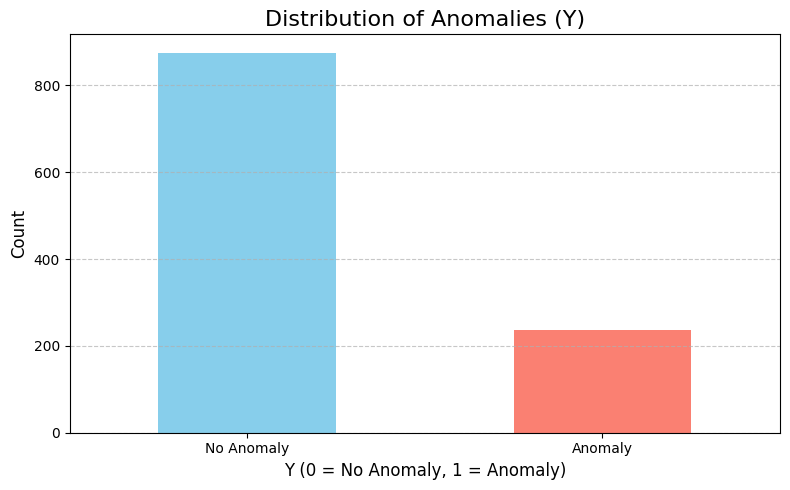

In [33]:
plot_anomaly_distribution(data)

In [34]:
# Plot anomalies against time
def plot_stock_price_against_time(df, interval=300, columns_to_plot=None):
    df['Data'] = pd.to_datetime(df['Data'])

    anomalies = df[df['Y'] == 1]
    plt.figure(figsize=(24, 8))

    for col in columns_to_plot:
        plt.plot(anomalies['Data'], anomalies[col], label=col)

    plt.title("Anomalies Over Time")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 1.0), ncol=5, fontsize=8)
    plt.grid(True)

    # Enhance X-axis display
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<ipython-input-34-ca35bef2de6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Data'] = pd.to_datetime(df['Data'])


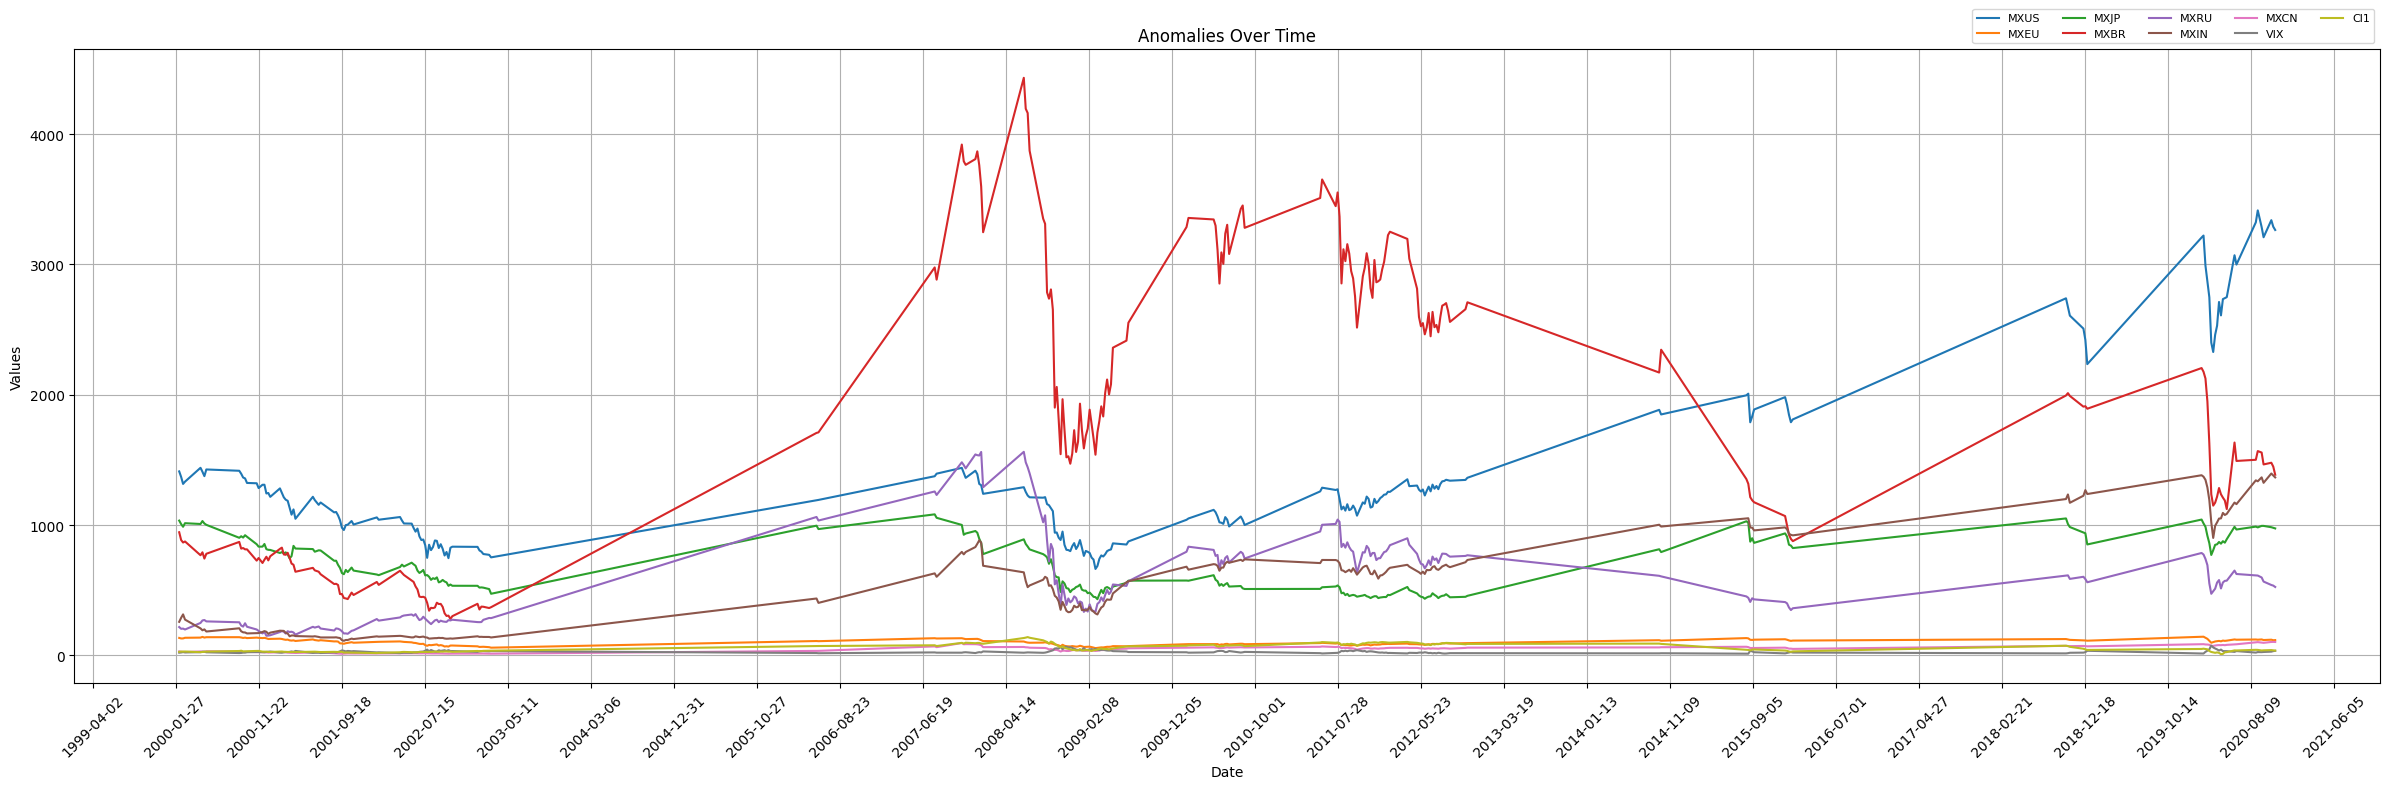

In [35]:
# Filter data and plot selected columns
columns_to_include = ['Y', 'Data', 'MXUS', 'MXEU', 'MXJP', 'MXBR', 'MXRU', 'MXIN', 'MXCN', 'VIX', 'Cl1']
data_selected = data[columns_to_include]
plot_stock_price_against_time(data_selected[data_selected['Y'] == 1], 300, columns_to_include[2:])

In [36]:
# Clean the dataset (remove missing values)
data['Data'] = pd.to_datetime(data['Data'], format='%m/%d/%Y')
data = data.dropna()

In [37]:
# Feature Engineering: Transform relevant columns
columns_to_transform = ['MXUS', 'MXEU', 'MXJP', 'VIX', 'Cl1']
# all columns
# columns_to_transform = [col for col in data.columns if col not in ['Y', 'Data']]
# data = data[columns_to_transform + ['Y', 'Data']]
# columns_to_transform = []
new_features = pd.DataFrame()

In [38]:
# Generate lag, rolling stats, and other features
for col in columns_to_transform:
    new_features[f'{col}_lag_1'] = data[col].shift(1)
    new_features[f'{col}_lag_2'] = data[col].shift(2)
    # new_features[f'{col}_lag_3'] = data[col].shift(3)
    # new_features[f'{col}_rolling_mean_5'] = data[col].rolling(window=5).mean()
    # new_features[f'{col}_rolling_std_5'] = data[col].rolling(window=5).std()
    # new_features[f'{col}_rolling_max_5'] = data[col].rolling(window=5).max()
    # new_features[f'{col}_pct_change'] = data[col].pct_change()
    # new_features[f'{col}_volatility'] = data[col].rolling(window=10).std()
    # new_features[f'{col}_roc'] = data[col].diff() / data[col].shift(1)
    # new_features[f'{col}_SMA_5'] = data[col].rolling(window=5).mean()
    # new_features[f'{col}_EMA_5'] = data[col].ewm(span=5).mean()

In [39]:
# Compute RSI for each column
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

for col in columns_to_transform:
    new_features[f'{col}_RSI'] = compute_rsi(data[col])

In [40]:
# Remove rows with NaN values generated by feature transformation
new_features = new_features.dropna()

In [41]:
# Concatenate the new features with the original data
data = pd.concat([data, new_features], axis=1)
data.dropna(inplace=True)

## Training Models

In [42]:
# print(data)
# Define features (X) and target (y)
X = data.drop(columns=['Y', 'Data'])
y = data['Y']

In [43]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest model
print("Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Model Evaluation:
Accuracy: 0.9227272727272727
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       175
           1       0.87      0.73      0.80        45

    accuracy                           0.92       220
   macro avg       0.90      0.85      0.87       220
weighted avg       0.92      0.92      0.92       220

Confusion Matrix:
[[170   5]
 [ 12  33]]


In [45]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [46]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,    # Decrease the learning rate
    max_depth=5,           # Increase depth of the trees
    scale_pos_weight=scale_pos_weight,   # Adjusting for class imbalance
    subsample=0.8,         # Use 80% of the data for training
    colsample_bytree=0.8,  # Use 80% of the features for each tree
    random_state=42,
)

xgb_model.fit(X_resampled, y_resampled)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost model
print("XGBoost Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Model Evaluation:
Accuracy: 0.9136363636363637
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       175
           1       0.72      0.93      0.82        45

    accuracy                           0.91       220
   macro avg       0.85      0.92      0.88       220
weighted avg       0.93      0.91      0.92       220

Confusion Matrix:
[[159  16]
 [  3  42]]


In [47]:
# Save requirements to 'requirements.txt'
!pip freeze > requirements.txt

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Exclude 'Y' and 'Data' for PCA
X = data.drop(columns=['Y', 'Data'])
y = data['Y']

# Standardize features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Train-test split for PCA-transformed data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train model on PCA-transformed data
model_pca = RandomForestClassifier(random_state=42)
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)

# Evaluate performance
print("Performance after PCA:")
print("Accuracy:", accuracy_score(y_test, y_pred_pca))
print(classification_report(y_test, y_pred_pca))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_pca))


Performance after PCA:
Accuracy: 0.9363636363636364
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       175
           1       0.92      0.76      0.83        45

    accuracy                           0.94       220
   macro avg       0.93      0.87      0.90       220
weighted avg       0.94      0.94      0.93       220

Confusion Matrix:
[[172   3]
 [ 11  34]]


In [49]:
# Compute the correlation matrix
correlation_matrix = X.corr()

# Select features with high correlation (e.g., |correlation| > 0.9)
threshold = 0.9
highly_correlated = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated.add(colname)

# Drop highly correlated features
X_corr_reduced = X.drop(columns=highly_correlated)

# Train-test split for correlation-reduced data
X_train_corr, X_test_corr, y_train, y_test = train_test_split(X_corr_reduced, y, test_size=0.2, random_state=42)

# Train model on correlation-reduced data
model_corr = RandomForestClassifier(random_state=42)
model_corr.fit(X_train_corr, y_train)
y_pred_corr = model_corr.predict(X_test_corr)

# Evaluate performance
print("Performance after Correlation Analysis:")
print("Accuracy:", accuracy_score(y_test, y_pred_corr))
print(classification_report(y_test, y_pred_corr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_corr))


Performance after Correlation Analysis:
Accuracy: 0.9409090909090909
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       175
           1       0.94      0.76      0.84        45

    accuracy                           0.94       220
   macro avg       0.94      0.87      0.90       220
weighted avg       0.94      0.94      0.94       220

Confusion Matrix:
[[173   2]
 [ 11  34]]


In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
print(data)
# Exclude 'Y' and 'Data' for PCA
X = data.drop(columns=['Y', 'Data'])
y = data['Y']

# Standardize features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Train-test split for PCA-transformed data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_pca = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss', random_state=42
    )
xgb_pca.fit(X_train_pca, y_train)
y_pred_pca = xgb_pca.predict(X_test_pca)

# Evaluate performance
print("Performance after PCA with XGBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_pca))
print(classification_report(y_test, y_pred_pca))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_pca))


      Y       Data  XAU BGNL  ECSURPUS    BDIY       CRY      DXY     JPY  \
13    0 2000-04-11    281.70     0.509  1684.0  162.6300  105.940  107.04   
14    0 2000-04-18    280.95     0.506  1670.0  167.5400  106.630  104.73   
15    1 2000-04-25    278.55     0.363  1647.0  168.7800  108.670  105.72   
16    1 2000-05-02    274.90     0.337  1622.0  173.7400  110.260  108.44   
17    1 2000-05-09    277.35     0.414  1609.0  177.2200  110.750  109.48   
...  ..        ...       ...       ...     ...       ...      ...     ...   
1106  0 2021-03-23   1727.96     0.339  2271.0  184.5022   92.336  108.72   
1107  0 2021-03-30   1685.56     0.303  2103.0  184.8741   93.297  110.29   
1108  0 2021-04-06   1743.28     0.440  2092.0  185.8393   92.335  109.88   
1109  0 2021-04-13   1742.69     0.467  2140.0  188.1368   91.852  109.19   
1110  0 2021-04-20   1779.72     0.492  2432.0  193.8035   91.147  108.09   

         GBP    Cl1  ...  MXJP_lag_2  VIX_lag_1  VIX_lag_2  Cl1_lag_1  \
13

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:46:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance after PCA with XGBoost:
Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       175
           1       0.93      0.82      0.87        45

    accuracy                           0.95       220
   macro avg       0.94      0.90      0.92       220
weighted avg       0.95      0.95      0.95       220

Confusion Matrix:
[[172   3]
 [  8  37]]


In [51]:
# Compute the correlation matrix
correlation_matrix = X.corr()

# Select features with high correlation (e.g., |correlation| > 0.9)
threshold = 0.9
highly_correlated = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated.add(colname)

# Drop highly correlated features
X_corr_reduced = X.drop(columns=highly_correlated)

# Train-test split for correlation-reduced data
X_train_corr, X_test_corr, y_train, y_test = train_test_split(X_corr_reduced, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_corr = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_corr.fit(X_train_corr, y_train)
y_pred_corr = xgb_corr.predict(X_test_corr)

# Evaluate performance
print("Performance after Correlation Analysis with XGBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_corr))
print(classification_report(y_test, y_pred_corr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_corr))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:46:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance after Correlation Analysis with XGBoost:
Accuracy: 0.9136363636363637
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       175
           1       0.80      0.78      0.79        45

    accuracy                           0.91       220
   macro avg       0.87      0.86      0.87       220
weighted avg       0.91      0.91      0.91       220

Confusion Matrix:
[[166   9]
 [ 10  35]]


In [52]:
# with pca and smote
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Exclude 'Y' and 'Data' for PCA
X = data.drop(columns=['Y', 'Data'])
y = data['Y']

# Train-test split before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Standardize features for PCA
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_smote_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train XGBoost model
xgb_pca = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_pca.fit(X_train_pca, y_train_smote)
y_pred_pca = xgb_pca.predict(X_test_pca)

# Evaluate performance
print("Performance after SMOTE and PCA with XGBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_pca))
print(classification_report(y_test, y_pred_pca))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_pca))


Performance after SMOTE and PCA with XGBoost:
Accuracy: 0.9181818181818182
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       175
           1       0.78      0.84      0.81        45

    accuracy                           0.92       220
   macro avg       0.87      0.89      0.88       220
weighted avg       0.92      0.92      0.92       220

Confusion Matrix:
[[164  11]
 [  7  38]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:46:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [53]:
# Define the hyperparameter grid for GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# different version for sklearn
from sklearn.base import BaseEstimator, ClassifierMixin

class SklearnXGBClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)

    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return self.model.get_params(deep)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self

xgb = SklearnXGBClassifier(objective='binary:logistic')
# grid_search = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=5, verbose=1)

In [54]:
# Grid search on the best performing above
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Exclude 'Y' and 'Data' for PCA
X = data.drop(columns=['Y', 'Data'])
y = data['Y']

# Standardize features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Train-test split for PCA-transformed data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define the XGBoost model
xgb_pca = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss', random_state=42
)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='recall', verbose=1, n_jobs=-1)

# Fit GridSearch
grid_search.fit(X_train_pca, y_train)

# Get the best estimator from GridSearch
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred_pca = best_model.predict(X_test_pca)

# Evaluate performance of the best model
print("Best Parameters from Grid Search:", grid_search.best_params_)
print("Performance after PCA with XGBoost and GridSearchCV:")
print("Accuracy:", accuracy_score(y_test, y_pred_pca))
print(classification_report(y_test, y_pred_pca))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_pca))


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters from Grid Search: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Performance after PCA with XGBoost and GridSearchCV:
Accuracy: 0.7954545454545454
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       175
           1       0.00      0.00      0.00        45

    accuracy                           0.80       220
   macro avg       0.40      0.50      0.44       220
weighted avg       0.63      0.80      0.70       220

Confusion Matrix:
[[175   0]
 [ 45   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

## Saving Performant Model

In [55]:
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Print the data
print(data)

# Exclude 'Y' and 'Data' for PCA
X = data.drop(columns=['Y', 'Data'])
y = data['Y']

# Standardize features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Train-test split for PCA-transformed data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_pca = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
xgb_pca.fit(X_train_pca, y_train)
y_pred_pca = xgb_pca.predict(X_test_pca)

# Evaluate performance
print("Performance after PCA with XGBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_pca))
print(classification_report(y_test, y_pred_pca))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_pca))

      Y       Data  XAU BGNL  ECSURPUS    BDIY       CRY      DXY     JPY  \
13    0 2000-04-11    281.70     0.509  1684.0  162.6300  105.940  107.04   
14    0 2000-04-18    280.95     0.506  1670.0  167.5400  106.630  104.73   
15    1 2000-04-25    278.55     0.363  1647.0  168.7800  108.670  105.72   
16    1 2000-05-02    274.90     0.337  1622.0  173.7400  110.260  108.44   
17    1 2000-05-09    277.35     0.414  1609.0  177.2200  110.750  109.48   
...  ..        ...       ...       ...     ...       ...      ...     ...   
1106  0 2021-03-23   1727.96     0.339  2271.0  184.5022   92.336  108.72   
1107  0 2021-03-30   1685.56     0.303  2103.0  184.8741   93.297  110.29   
1108  0 2021-04-06   1743.28     0.440  2092.0  185.8393   92.335  109.88   
1109  0 2021-04-13   1742.69     0.467  2140.0  188.1368   91.852  109.19   
1110  0 2021-04-20   1779.72     0.492  2432.0  193.8035   91.147  108.09   

         GBP    Cl1  ...  MXJP_lag_2  VIX_lag_1  VIX_lag_2  Cl1_lag_1  \
13

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:48:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [56]:

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the PCA object
with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

# Save the XGBoost model
xgb_pca.save_model('xgb_model.json')

print("Models and preprocessing objects saved successfully.")


Models and preprocessing objects saved successfully.


### Loading Model

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 76.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [71]:

def transform_features(data, columns_to_transform=['MXUS', 'MXEU', 'MXJP', 'VIX', 'Cl1'], include_rsi=True, lags=[1, 2]):
    """
    Generate lag, rolling statistics, and other features for specified columns in a DataFrame.

    Parameters:
    - data (pd.DataFrame): Input data containing columns to transform.
    - columns_to_transform (list): List of column names to apply transformations to.
    - include_rsi (bool): Whether to compute and include RSI features.
    - lags (list): List of lag periods to generate lag features for.

    Returns:
    - pd.DataFrame: Transformed data with the new features concatenated.
    """
    new_features = pd.DataFrame(index=data.index)

    # Generate lag features
    for col in columns_to_transform:
        for lag in lags:
            new_features[f'{col}_lag_{lag}'] = data[col].shift(lag)

    # Compute RSI for each column if include_rsi is True
    if include_rsi:
        def compute_rsi(series, window=14):
            delta = series.diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
            rs = gain / loss
            return 100 - (100 / (1 + rs))

        for col in columns_to_transform:
            new_features[f'{col}_RSI'] = compute_rsi(data[col])

    # # Remove rows with NaN values generated by feature transformation
    new_features.dropna(inplace=True)

    # Concatenate the new features with the original data
    transformed_data = pd.concat([data, new_features], axis=1)
    print(transformed_data)
    transformed_data.dropna(inplace=True)

    return transformed_data


In [73]:
import numpy as np
import pandas as pd
import pickle
from xgboost import XGBClassifier

# Load preprocessing objects and model
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('pca.pkl', 'rb') as f:
    pca = pickle.load(f)

xgb_model = XGBClassifier()
xgb_model.load_model('xgb_model.json')

# Define the predict function
def predict_outcome(data: pd.DataFrame) -> np.ndarray:
    """
    Predicts outcomes based on input data.

    Args:
        data (pd.DataFrame): Input data containing feature columns for prediction.

    Returns:
        np.ndarray: Predicted labels (0 or 1).
    """
    # Drop non-feature columns (e.g., date column if present)
    feature_columns = data.drop(columns=['Y', 'Data'], errors='ignore')

    # Ensure the features are numerical
    feature_data = feature_columns.apply(pd.to_numeric, errors='coerce').fillna(0).values

    # Scale and transform data
    scaled_data = scaler.transform(feature_data)
    transformed_data = pca.transform(scaled_data)

    # Predict outcomes
    predictions = xgb_model.predict(transformed_data)
    return predictions

# Example usage with your provided training data
# Convert raw data into a DataFrame
raw_data = """
Y,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,USGG30YR,GT10,USGG2YR,USGG3M,US0001M,GTDEM30Y,GTDEM10Y,GTDEM2Y,EONIA,GTITL30YR,GTITL10YR,GTITL2YR,GTJPY30YR,GTJPY10YR,GTJPY2YR,GTGBP30Y,GTGBP20Y,GTGBP2Y,LUMSTRUU,LMBITR,LUACTRUU,LF98TRUU,LG30TRUU,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,1/18/2000,287.650,0.043,1405.000,165.010,101.860,105.470,1.638,28.850,21.500,6.747,6.748,6.465,5.378,5.803,6.254,5.644,4.321,3.030,6.459,5.889,4.535,2.418,1.765,0.349,4.746,4.975,6.613,869.330,473.223,990.480,545.680,305.303,117.267,231.377,123.762,1428.790,129.500,993.980,925.220,234.370,227.080,32.740
0,1/25/2000,287.150,0.135,1368.000,167.240,102.410,106.040,1.650,28.280,23.020,6.634,6.692,6.432,5.562,5.819,6.045,5.515,4.270,3.150,6.281,5.760,4.511,2.259,1.625,0.293,4.691,4.900,6.521,873.500,472.723,997.680,546.700,306.181,117.995,232.390,123.762,1385.930,126.480,974.830,886.930,216.820,233.000,32.460
0,2/1/2000,282.750,0.191,1311.000,166.850,104.920,107.850,1.611,28.220,23.450,6.423,6.619,6.574,5.708,5.885,5.944,5.459,4.326,3.300,6.188,5.710,4.540,2.330,1.770,0.364,4.593,4.794,6.467,871.220,473.255,997.910,547.380,305.997,120.510,231.942,122.328,1385.310,129.190,1007.120,842.600,201.890,237.480,31.290
1,2/8/2000,298.400,0.312,1277.000,165.430,104.220,109.300,1.611,28.020,21.250,6.231,6.613,6.678,5.677,5.891,5.850,5.482,4.390,3.260,6.118,5.728,4.638,2.481,1.919,0.359,4.548,4.768,6.472,872.390,474.733,998.770,548.250,309.476,118.791,237.812,122.328,1411.950,134.670,1034.580,945.150,218.000,258.020,31.320
1,2/15/2000,303.900,0.391,1393.000,169.580,104.690,108.730,1.597,30.060,22.920,6.246,6.552,6.628,5.740,5.880,5.900,5.562,4.419,3.250,6.171,5.814,4.651,2.309,1.801,0.333,4.647,4.871,6.376,873.350,475.192,997.720,548.170,310.577,118.608,240.116,122.328,1369.470,130.600,1007.860,885.560,204.590,288.980,27.660
1,2/22/2000,305.500,0.497,1481.000,168.860,103.280,110.920,1.617,29.620,25.860,6.086,6.361,6.551,5.764,5.880,5.735,5.415,4.434,3.200,6.019,5.669,4.648,2.332,1.860,0.304,4.471,4.698,6.360,878.810,476.498,1009.070,549.290,311.078,118.313,240.144,122.328,1315.930,130.850,987.380,866.460,206.140,315.210,27.950
1,2/29/2000,293.300,0.497,1531.000,170.200,105.920,109.970,1.580,30.430,23.370,6.140,6.409,6.521,5.781,5.913,5.866,5.500,4.439,3.340,6.146,5.770,4.664,2.341,1.844,0.378,4.542,4.763,6.410,879.570,478.746,1004.660,547.990,312.082,119.962,243.105,122.002,1333.280,135.710,1014.690,874.470,199.230,275.100,26.200
0,3/7/2000,292.000,0.484,1602.000,179.940,106.010,106.100,1.576,34.130,24.310,6.145,6.373,6.486,5.834,5.950,5.811,5.432,4.469,3.280,6.100,5.705,4.683,2.174,1.792,0.423,4.329,4.563,6.298,883.060,479.716,1007.300,548.500,314.149,121.394,246.522,122.002,1319.950,141.850,994.720,918.790,234.180,283.740,26.540
0,3/14/2000,289.600,0.488,1645.000,175.670,105.200,104.840,1.575,31.690,24.410,6.090,6.292,6.468,5.886,6.004,5.754,5.359,4.500,3.520,6.042,5.636,4.681,2.289,1.814,0.430,4.415,4.650,6.329,882.520,481.542,1004.170,547.910,314.588,121.454,247.661,122.002,1324.430,138.600,943.050,868.240,263.280,253.360,27.350
0,3/21/2000,290.830,0.566,1624.000,171.250,105.810,106.980,1.572,28.000,21.700,5.969,6.135,6.502,5.918,6.113,5.564,5.221,4.421,3.490,5.858,5.503,4.590,2.339,1.884,0.494,4.315,4.559,6.292,887.030,484.823,1010.440,546.840,315.483,121.144,249.914,122.002,1457.010,139.930,987.770,905.210,249.450,238.150,25.740
0,3/28/2000,279.900,0.572,1627.000,170.050,105.530,105.930,1.588,27.090,24.860,5.977,6.151,6.598,5.886,6.131,5.620,5.278,4.465,3.590,5.931,5.555,4.646,2.350,1.875,0.492,4.489,4.703,6.435,883.360,488.362,1008.690,544.410,315.174,121.071,250.974,122.002,1474.820,142.680,1009.100,914.400,268.410,259.640,27.330
0,4/4/2000,287.400,0.631,1676.000,166.010,105.170,104.660,1.602,25.450,27.120,5.773,5.895,6.308,5.876,6.131,5.569,5.182,4.391,3.750,5.869,5.482,4.585,2.205,1.782,0.439,4.467,4.663,6.389,897.260,489.214,1021.250,536.900,311.147,120.060,248.429,124.639,1465.450,137.990,1039.550,864.740,267.670,226.130,26.420
0,4/11/2000,281.700,0.509,1684.000,162.630,105.940,107.040,1.587,24.140,27.250,5.770,5.882,6.331,5.844,6.130,5.521,5.162,4.390,3.580,5.843,5.443,4.583,2.077,1.742,0.414,4.451,4.641,6.287,895.220,491.498,1017.810,538.450,311.358,120.212,247.732,124.639,1468.750,136.710,1028.540,860.380,259.180,262.490,26.460
0,4/18/2000,280.950,0.506,1670.000,167.540,106.630,104.730,1.579,26.110,26.120,5.910,6.059,6.329,5.813,6.130,5.609,5.253,4.429,3.610,5.929,5.535,4.622,2.042,1.713,0.414,4.574,4.762,6.286,896.090,490.060,1010.630,537.470,309.803,120.195,245.635,124.639,1410.470,132.970,967.700,782.600,235.120,219.970,29.590
1,4/25/2000,278.550,0.363,1647.000,168.780,108.670,105.720,1.580,25.330,25.240,5.936,6.128,6.484,5.813,6.150,5.675,5.334,4.560,3.350,5.986,5.620,4.730,2.101,1.718,0.384,4.597,4.783,6.348,894.200,489.058,1009.420,538.790,310.946,121.397,247.136,124.639,1439.630,137.080,1008.620,768.910,249.610,207.690,30.790
1,5/2/2000,274.900,0.337,1622.000,173.740,110.260,108.440,1.559,26.890,28.500,6.011,6.299,6.711,5.918,6.291,5.641,5.343,4.695,3.930,5.963,5.625,4.854,2.175,1.730,0.356,4.457,4.653,6.196,888.770,486.321,1001.050,537.670,309.898,122.279,246.095,124.358,1409.110,142.610,1031.160,791.300,268.600,193.260,29.530
1,5/9/2000,277.350,0.414,1609.000,177.220,110.750,109.480,1.532,28.650,28.930,6.213,6.529,6.843,6.138,6.461,5.620,5.355,4.786,4.030,5.989,5.705,4.956,2.147,1.711,0.320,4.495,4.712,6.290,878.130,480.600,986.940,537.980,306.686,121.607,240.071,124.358,1375.570,137.330,1012.280,743.210,272.040,200.090,28.120
1,5/16/2000,275.850,0.400,1612.000,182.080,111.310,109.730,1.499,29.730,24.340,6.113,6.424,6.872,6.211,6.570,5.567,5.348,4.852,3.900,5.975,5.706,5.028,2.201,1.744,0.343,4.487,4.718,6.336,879.560,479.047,990.920,538.500,306.731,120.103,239.814,124.358,1426.880,140.150,1002.210,780.030,261.520,183.770,32.290
0,5/23/2000,274.150,0.420,1598.000,182.560,111.440,106.780,1.475,28.780,25.870,6.160,6.435,6.788,5.938,6.610,5.545,5.342,4.958,3.790,6.033,5.743,5.151,2.326,1.716,0.314,4.612,4.835,6.267,882.420,478.655,990.460,535.500,303.868,117.021,236.653,124.358,1337.550,132.590,942.830,694.360,202.110,169.390,30.110
0,5/30/2000,273.350,0.336,1569.000,184.890,108.930,106.470,1.496,30.350,23.620,6.092,6.376,6.731,5.764,6.615,5.464,5.241,4.924,4.020,5.913,5.603,5.110,2.191,1.716,0.333,4.457,4.693,6.234,886.950,481.789,996.600,531.960,305.059,115.248,240.921,124.358,1379.850,135.690,943.510,782.020,226.740,181.380,28.380
0,6/6/2000,288.750,0.027,1559.000,184.250,106.590,105.860,1.527,29.750,23.050,5.908,6.122,6.492,5.985,6.623,5.409,5.138,4.760,4.160,5.895,5.527,4.960,2.283,1.716,0.483,4.412,4.628,6.130,904.130,487.542,1016.260,535.510,308.928,116.452,245.360,121.331,1412.520,139.100,983.030,830.490,234.240,196.460,32.600
"""

# Parse the raw data string into a pandas DataFrame
from io import StringIO

data_df = pd.read_csv(StringIO(raw_data))
data_df = transform_features(data_df)
# Use the predict function
predicted_outcomes = predict_outcome(data_df)

print("Predicted outcomes:", predicted_outcomes)


    Y       Data  XAU BGNL  ECSURPUS    BDIY     CRY     DXY     JPY    GBP  \
0   0  1/18/2000    287.65     0.043  1405.0  165.01  101.86  105.47  1.638   
1   0  1/25/2000    287.15     0.135  1368.0  167.24  102.41  106.04  1.650   
2   0   2/1/2000    282.75     0.191  1311.0  166.85  104.92  107.85  1.611   
3   1   2/8/2000    298.40     0.312  1277.0  165.43  104.22  109.30  1.611   
4   1  2/15/2000    303.90     0.391  1393.0  169.58  104.69  108.73  1.597   
5   1  2/22/2000    305.50     0.497  1481.0  168.86  103.28  110.92  1.617   
6   1  2/29/2000    293.30     0.497  1531.0  170.20  105.92  109.97  1.580   
7   0   3/7/2000    292.00     0.484  1602.0  179.94  106.01  106.10  1.576   
8   0  3/14/2000    289.60     0.488  1645.0  175.67  105.20  104.84  1.575   
9   0  3/21/2000    290.83     0.566  1624.0  171.25  105.81  106.98  1.572   
10  0  3/28/2000    279.90     0.572  1627.0  170.05  105.53  105.93  1.588   
11  0   4/4/2000    287.40     0.631  1676.0  166.01

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
